# Rescheduling mit Tardiness (Summe)
> Planunghorizont Tag 0: 2 Tage
> Rescheduling des Tages 1

In [1]:
from configs.config import get_path
import src.utils.presenter as show
import src.utils.checker as check

import math
import pandas as pd
pd.set_option('display.max_rows', 21)

import src.utils.gen_jobs as gen_jobs
import src.utils.gen_deadline as gen_deadline
import src.utils.rolling_scheduling as rolling_schedule

import src.models.cp.lateness as solver
import src.models.heuristics.fcfs as heuristics

import numpy as np
from ortools.sat.python import cp_model

from src.simulation.ProductionDaySimulation import ProductionDaySimulation
import time

In [2]:
max_time = 60 * 20 # 20 min

In [3]:
basic_data_path = get_path("data", "basic")
df_instance = pd.read_csv(basic_data_path / "00_instance.csv")

df_ops, df_jobs_arrivals = gen_jobs.create_jobs_for_days(df_instance, day_count = 1, u_b_mmax= 0.94, shuffle = True)
df_ops

,Job,Operation,Machine,Processing Time
0,Job_000,0,M0,29
1,Job_000,1,M1,78
2,Job_000,2,M2,9
3,Job_000,3,M3,36
4,Job_000,4,M4,49
...,...,...,...,...
315,Job_031,5,M1,28
316,Job_031,6,M6,46
317,Job_031,7,M5,46
318,Job_031,8,M7,72


In [4]:
# a) Initialisierung der Deadlines
df_jobs = gen_deadline.get_times_df(df_ops, df_jobs_arrivals, heuristics.schedule_fcfs_with_arrivals, target_service=1.0)

# Rundung für CP 
df_jobs["Arrival"] = np.floor(df_jobs["Arrival"]).astype(int)
df_jobs["Deadline"] = np.ceil(df_jobs["Deadline"]).astype(int)
df_jobs.head()

,Job,Arrival,Deadline
0,Job_000,0,1323
1,Job_001,81,1789
2,Job_002,101,2004
3,Job_003,142,2335
4,Job_004,177,1493


In [5]:
# b) Bestimmung der "Ready Time"
df_jobs['Ready Time'] = ((df_jobs['Arrival'] // 1440) + 1) * 1440

# c) Processing Time
processing_time = df_ops.groupby('Job')['Processing Time'].sum()
df_jobs = pd.merge(df_jobs, processing_time, on='Job')

# d) Bestimmung des Slacks
df_jobs['Slack'] = df_jobs['Deadline'] - (df_jobs['Ready Time'] + df_jobs['Processing Time'])

# e) Anpassung der Deadlines
min_slack = df_jobs['Slack'].min()

if min_slack < 0:
    df_jobs["Deadline"] = df_jobs["Deadline"] + abs(min_slack)
df_jobs

# f) erneute Bestimmung des Slacks
df_jobs['Slack'] = df_jobs['Deadline'] - (df_jobs['Ready Time'] + df_jobs['Processing Time'])
df_jobs 

,Job,Arrival,Deadline,Ready Time,Processing Time,Slack
0,Job_000,0,1835,1440,395,0
1,Job_001,81,2301,1440,510,351
2,Job_002,101,2516,1440,568,508
3,Job_003,142,2847,1440,655,752
4,Job_004,177,2005,1440,393,172
...,...,...,...,...,...,...
27,Job_027,1390,3707,1440,539,1728
28,Job_028,1391,3226,1440,395,1391
29,Job_029,1410,3239,1440,393,1406
30,Job_030,1423,3258,1440,395,1423


In [6]:
day_length = 1440

## I) Tag 1

In [7]:
day_numb = 1

day_start = day_length*day_numb 
day_end = day_start + day_length
print(f"Tag {day_numb:02d}: [{day_start}, {day_end})")

Tag 01: [1440, 2880)


In [8]:
def filter_ops_and_jobs_by_ready_time(df_jobs: pd.DataFrame, df_ops: pd.DataFrame, 
                              ready_time_col = "Ready Time", ready_time: int = 0) -> tuple[pd.DataFrame, pd.DataFrame]:

    # Jobs zeitlich filtern
    time_filter = df_jobs[ready_time_col] == ready_time
    df_jobs_filtered = df_jobs[time_filter].copy()

    # Operationen nach (gefilterten) Jobs filtern
    jobs = df_jobs_filtered["Job"]
    df_ops_filtered = df_ops[df_ops["Job"].isin(jobs)].copy()
    return df_jobs_filtered, df_ops_filtered

In [9]:
df_jobs_curr, df_ops_curr = filter_ops_and_jobs_by_ready_time(df_jobs, df_ops, ready_time = day_start)
df_jobs_curr

,Job,Arrival,Deadline,Ready Time,Processing Time,Slack
0,Job_000,0,1835,1440,395,0
1,Job_001,81,2301,1440,510,351
2,Job_002,101,2516,1440,568,508
3,Job_003,142,2847,1440,655,752
4,Job_004,177,2005,1440,393,172
...,...,...,...,...,...,...
27,Job_027,1390,3707,1440,539,1728
28,Job_028,1391,3226,1440,395,1391
29,Job_029,1410,3239,1440,393,1406
30,Job_030,1423,3258,1440,395,1423


### A) Scheduling für Tag 1

In [10]:
starting_time = time.time()

# Scheduling
df_plan = solver.solve_cp_jssp_lateness_by_tardiness_and_earliness(df_ops_curr, df_jobs_curr, w_t = 5,
                                                                schedule_start = 1440,
                                                                msg=False, timeLimit=max_time, gapRel= 0.00)
df_plan

# Informationen
ending_time = time.time()
solver_duration = ending_time - starting_time
print(f"\nScheduling-Dauer: {int(solver_duration // 60)} Minuten und {(solver_duration % 60):.2f} Sekunden.")
df_plan


Solver-Status         : FEASIBLE
Objective Value       : 2262.00
Best Objective Bound  : 590.00
Laufzeit              : 1200.47 Sekunden

Scheduling-Dauer: 20 Minuten und 0.51 Sekunden.


,Job,Operation,Machine,Arrival,Deadline,Start,Processing Time,End,Lateness,Tardiness,Earliness
0,Job_000,0,M0,0,1835,1440,29,1469,-366,0,366
1,Job_004,0,M2,177,2005,1440,14,1454,-551,0,551
2,Job_015,0,M1,555,2461,1440,46,1486,-975,0,975
3,Job_027,0,M2,1390,3707,1454,31,1485,-2222,0,2222
4,Job_004,1,M0,177,2005,1469,6,1475,-530,0,530
...,...,...,...,...,...,...,...,...,...,...,...
315,Job_023,9,M8,1211,3723,3649,74,3723,0,0,0
316,Job_024,6,M7,1238,3944,3649,85,3734,-210,0,210
317,Job_024,7,M3,1238,3944,3734,98,3832,-112,0,112
318,Job_024,8,M9,1238,3944,3832,22,3854,-90,0,90


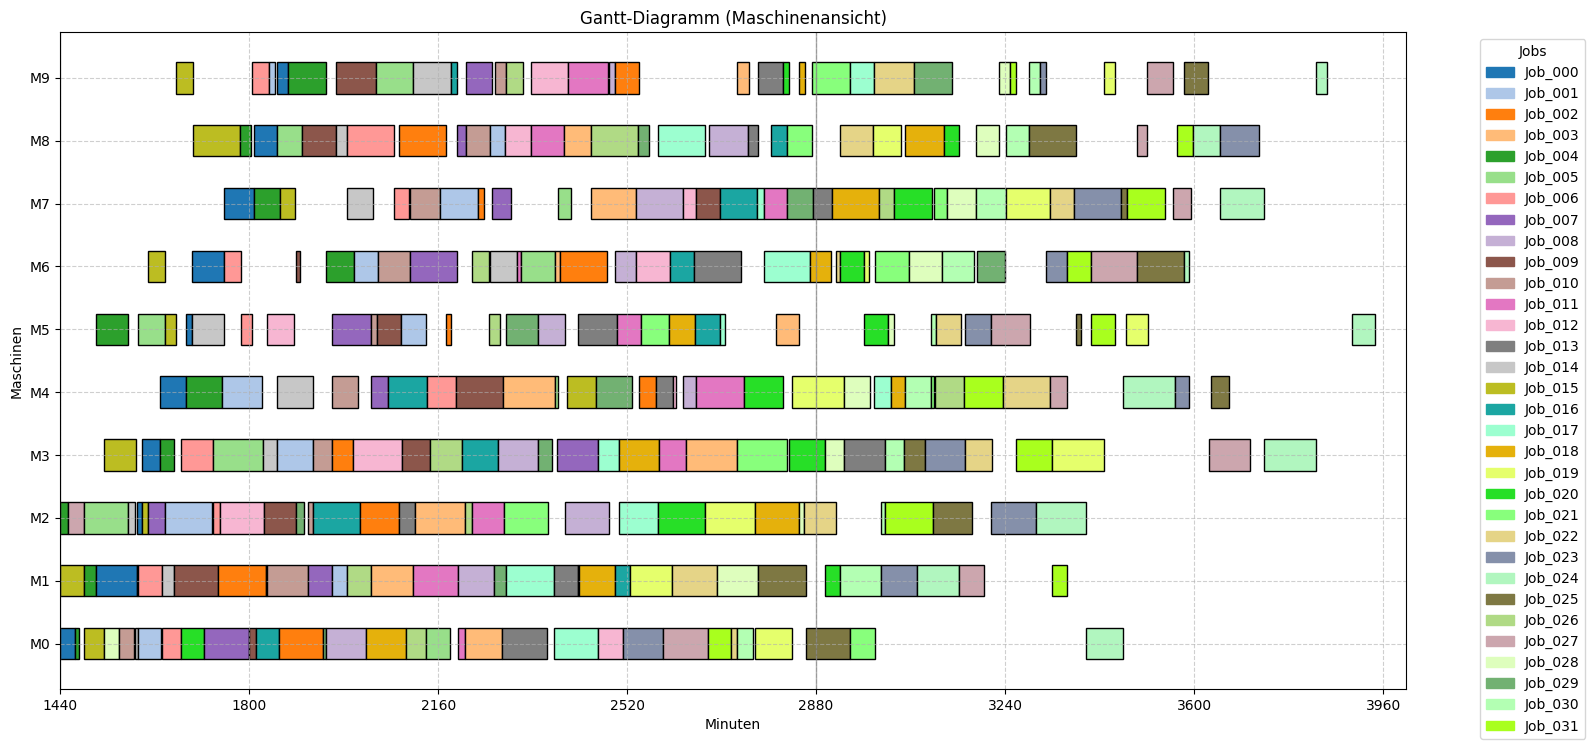

+ Keine Maschinenkonflikte gefunden
+ Alle Jobs wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten sind eingehalten.
+ Alle Operation starten erst nach Arrival des Job


True

In [11]:
show.plot_gantt_machines(df_plan)

check.is_machine_conflict_free(df_plan)
check.is_operation_sequence_correct(df_plan)
check.is_job_timing_correct(df_plan)
check.is_start_correct(df_plan)

### B) Aufteilung in heutige und zukünftge Operationen

In [12]:
def filter_plan_for_today(df_plan, latest_op_start: int = 0): # exclusive
    filt = (df_plan.Start < latest_op_start)
    return df_plan[filt].sort_values(by="Job").reset_index(drop=True)

In [13]:
df_plan_for_sim = filter_plan_for_today(df_plan, latest_op_start = day_end)
df_plan_for_sim

,Job,Operation,Machine,Arrival,Deadline,Start,Processing Time,End,Lateness,Tardiness,Earliness
0,Job_000,0,M0,0,1835,1440,29,1469,-366,0,366
1,Job_000,3,M3,0,1835,1595,36,1631,-204,0,204
2,Job_000,5,M5,0,1835,1680,11,1691,-144,0,144
3,Job_000,2,M2,0,1835,1586,9,1595,-240,0,240
4,Job_000,6,M6,0,1835,1691,62,1753,-82,0,82
...,...,...,...,...,...,...,...,...,...,...,...
223,Job_029,5,M4,1410,3239,2461,69,2530,-709,0,709
224,Job_029,7,M7,1410,3239,2825,49,2874,-365,0,365
225,Job_029,4,M3,1410,3239,2350,26,2376,-863,0,863
226,Job_030,0,M0,1423,3258,2730,29,2759,-499,0,499


In [14]:
def filter_plan_for_future(df_plan, earliest_op_start: int = 0):
    filt = (df_plan.Start >= earliest_op_start)
    return df_plan[filt].sort_values(by=["Job", "Start"]).reset_index(drop=True)

In [15]:
df_plan_waiting = filter_plan_for_future(df_plan, earliest_op_start = day_end)
df_plan_waiting

,Job,Operation,Machine,Arrival,Deadline,Start,Processing Time,End,Lateness,Tardiness,Earliness
0,Job_013,9,M3,535,2852,2933,79,3012,160,160,0
1,Job_017,8,M9,625,3040,2945,45,2990,-50,0,50
2,Job_017,9,M4,625,3040,2990,33,3023,-17,0,17
3,Job_018,7,M7,682,3193,2910,89,2999,-194,0,194
4,Job_018,8,M4,682,3193,3023,26,3049,-144,0,144
...,...,...,...,...,...,...,...,...,...,...,...
87,Job_031,5,M1,1424,3644,3330,28,3358,-286,0,286
88,Job_031,6,M6,1424,3644,3358,46,3404,-240,0,240
89,Job_031,7,M5,1424,3644,3404,46,3450,-194,0,194
90,Job_031,8,M7,1424,3644,3472,72,3544,-100,0,100


### C) Simulation

In [16]:
simulation = ProductionDaySimulation(df_plan_for_sim, vc=0.35)
df_execution, df_plan_undone = simulation.run(start_time = day_start, end_time=day_end)

[24:00:00] Job_000 started on M0
[24:00:00] Job_004 started on M2
[24:00:00] Job_015 started on M1
[24:09:00] Job_004 finished on M2 (after 09 minutes 01 second)
[24:14:00] Job_027 started on M2
[24:44:40] Job_027 finished on M2 (after 30 minutes 41 seconds)
[24:45:00] Job_005 started on M2
[25:03:06] Job_015 finished on M1 (after 63 minutes 07 seconds)
[25:16:09] Job_000 finished on M0 (after 76 minutes 10 seconds)
[25:16:09] Job_004 started on M0
[25:16:09] Job_000 started on M1
[25:24:14] Job_004 finished on M0 (after 08 minutes 05 seconds)
[25:24:14] Job_015 started on M0
[26:02:37] Job_015 finished on M0 (after 38 minutes 23 seconds)
[26:02:37] Job_028 started on M0
[26:02:37] Job_015 started on M3
[26:04:55] Job_000 finished on M1 (after 48 minutes 46 seconds)
[26:04:55] Job_004 started on M1
[26:19:58] Job_004 finished on M1 (after 15 minutes 03 seconds)
[26:19:58] Job_004 started on M5
[26:20:36] Job_005 finished on M2 (after 95 minutes 37 seconds)
[26:20:36] Job_014 started on

In [17]:
df_plan_undone

,Job,Operation,Arrival,Machine,Planned Start,Processing Time
1,Job_003,6,142,M7,2452,85
6,Job_008,7,329,M7,2537,89
35,Job_029,6,1410,M8,2541,21
0,Job_002,9,101,M4,2542,33
20,Job_017,4,625,M8,2578,90
...,...,...,...,...,...,...
31,Job_022,2,1050,M2,2857,61
33,Job_025,1,1252,M0,2860,85
23,Job_018,6,682,M6,2869,40
30,Job_021,5,970,M9,2873,72


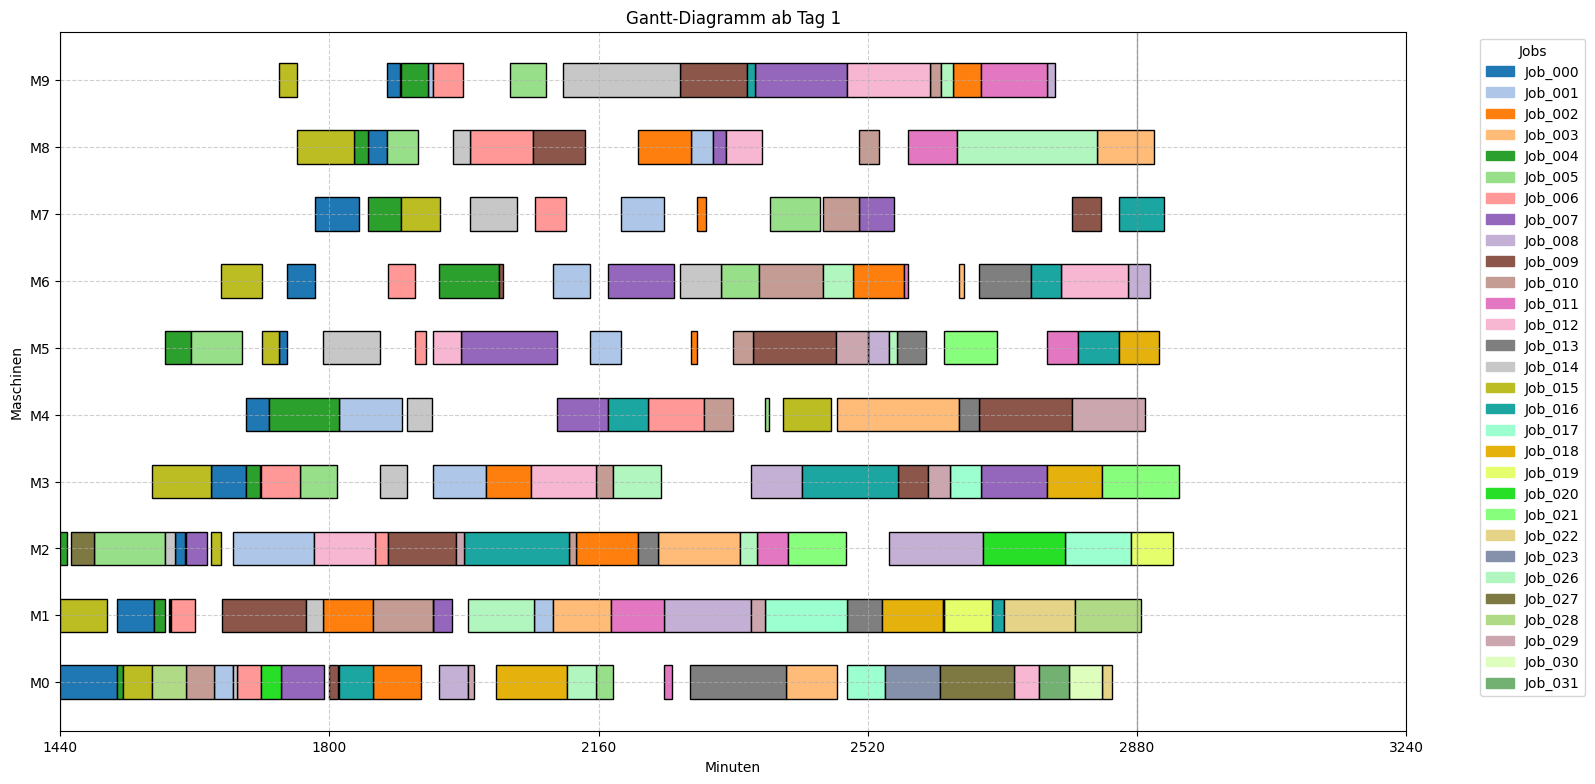

In [18]:
if not df_execution.empty:
    show.plot_gantt_machines(df_execution, title=f"Gantt-Diagramm ab Tag {day_numb}", duration_column="Simulated Processing Time")
else:
    print(f"Nothing executed on day {day_numb}")

## II) Tag 2
> vereinfacht, ohne neu Aufträge (nur der Rest)

In [19]:
day_numb = 2

day_start = day_length*day_numb 
day_end = day_start + day_length
print(f"Tag {day_numb:02d}: [{day_start}, {day_end})")

Tag 02: [2880, 4320)


#### a) Filtern nach der aktuellen "Ready Time"

In [20]:
df_jobs_curr, df_ops_curr = filter_ops_and_jobs_by_ready_time(df_jobs, df_ops, ready_time = day_start)
df_jobs_curr

,Job,Arrival,Deadline,Ready Time,Processing Time,Slack


### b) Operationen, die zuvor "ready" waren, aber noch nicht starten sollten

In [21]:
df_plan_waiting

,Job,Operation,Machine,Arrival,Deadline,Start,Processing Time,End,Lateness,Tardiness,Earliness
0,Job_013,9,M3,535,2852,2933,79,3012,160,160,0
1,Job_017,8,M9,625,3040,2945,45,2990,-50,0,50
2,Job_017,9,M4,625,3040,2990,33,3023,-17,0,17
3,Job_018,7,M7,682,3193,2910,89,2999,-194,0,194
4,Job_018,8,M4,682,3193,3023,26,3049,-144,0,144
...,...,...,...,...,...,...,...,...,...,...,...
87,Job_031,5,M1,1424,3644,3330,28,3358,-286,0,286
88,Job_031,6,M6,1424,3644,3358,46,3404,-240,0,240
89,Job_031,7,M5,1424,3644,3404,46,3450,-194,0,194
90,Job_031,8,M7,1424,3644,3472,72,3544,-100,0,100


In [22]:
# Sicherstellen, dass beide DataFrames die Spalten 'Job' und 'Operation' haben
df_ops_waiting = df_ops.merge(df_plan_waiting[["Job", "Operation"]], on=["Job", "Operation"], how="inner")
df_ops_waiting

,Job,Operation,Machine,Processing Time
0,Job_013,9,M3,79
1,Job_017,8,M9,45
2,Job_017,9,M4,33
3,Job_018,7,M7,89
4,Job_018,8,M4,26
...,...,...,...,...
87,Job_031,5,M1,28
88,Job_031,6,M6,46
89,Job_031,7,M5,46
90,Job_031,8,M7,72


In [23]:
df_jobs_waiting = df_jobs[df_jobs["Job"].isin(df_plan_waiting["Job"].unique())]
df_jobs_waiting

,Job,Arrival,Deadline,Ready Time,Processing Time,Slack
13,Job_013,535,2852,1440,539,873
17,Job_017,625,3040,1440,568,1032
18,Job_018,682,3193,1440,597,1156
19,Job_019,808,3513,1440,655,1418
20,Job_020,931,3151,1440,510,1201
21,Job_021,970,3143,1440,496,1207
22,Job_022,1050,3371,1440,540,1391
23,Job_023,1211,3723,1440,597,1686
24,Job_024,1238,3944,1440,655,1849
25,Job_025,1252,3666,1440,568,1658


#### c) Unerledigte Operationen

In [24]:
df_plan_undone

,Job,Operation,Arrival,Machine,Planned Start,Processing Time
1,Job_003,6,142,M7,2452,85
6,Job_008,7,329,M7,2537,89
35,Job_029,6,1410,M8,2541,21
0,Job_002,9,101,M4,2542,33
20,Job_017,4,625,M8,2578,90
...,...,...,...,...,...,...
31,Job_022,2,1050,M2,2857,61
33,Job_025,1,1252,M0,2860,85
23,Job_018,6,682,M6,2869,40
30,Job_021,5,970,M9,2873,72


In [25]:
# Sicherstellen, dass beide DataFrames die Spalten 'Job' und 'Operation' haben
df_ops_undone = df_ops.merge(df_plan_undone[["Job", "Operation"]], on=["Job", "Operation"], how="inner")
df_ops_undone

,Job,Operation,Machine,Processing Time
0,Job_002,9,M4,33
1,Job_003,6,M7,85
2,Job_003,7,M3,98
3,Job_003,8,M9,22
4,Job_003,9,M5,43
...,...,...,...,...
32,Job_025,0,M1,91
33,Job_025,1,M0,85
34,Job_028,2,M2,9
35,Job_029,6,M8,21


In [26]:
df_jobs_undone = df_jobs[df_jobs["Job"].isin(df_ops_undone["Job"].unique())]
df_jobs_undone

,Job,Arrival,Deadline,Ready Time,Processing Time,Slack
2,Job_002,101,2516,1440,568,508
3,Job_003,142,2847,1440,655,752
8,Job_008,329,2841,1440,597,804
11,Job_011,498,2819,1440,540,839
12,Job_012,505,2678,1440,496,742
13,Job_013,535,2852,1440,539,873
16,Job_016,610,2830,1440,510,880
17,Job_017,625,3040,1440,568,1032
18,Job_018,682,3193,1440,597,1156
19,Job_019,808,3513,1440,655,1418


### Zusammenführen

In [27]:
# Operationen
df_ops_curr_all = pd.concat([df_ops_curr, df_ops_waiting, df_ops_undone], ignore_index=True)
df_ops_curr_all = df_ops_curr_all.sort_values(by=["Job", "Operation"]).reset_index(drop=True)
df_ops_curr_all

,Job,Operation,Machine,Processing Time
0,Job_002,9,M4,33
1,Job_003,6,M7,85
2,Job_003,7,M3,98
3,Job_003,8,M9,22
4,Job_003,9,M5,43
...,...,...,...,...
124,Job_031,5,M1,28
125,Job_031,6,M6,46
126,Job_031,7,M5,46
127,Job_031,8,M7,72


In [28]:
df_jobs_curr_all = pd.concat([df_jobs_curr, df_jobs_waiting, df_jobs_undone], ignore_index=True)
df_jobs_curr_all = df_jobs_curr_all.drop_duplicates(subset="Job", keep="first").sort_values(by="Job").reset_index(drop=True)
df_jobs_curr_all

,Job,Arrival,Deadline,Ready Time,Processing Time,Slack
0,Job_002,101,2516,1440,568,508
1,Job_003,142,2847,1440,655,752
2,Job_008,329,2841,1440,597,804
3,Job_011,498,2819,1440,540,839
4,Job_012,505,2678,1440,496,742
...,...,...,...,...,...,...
17,Job_027,1390,3707,1440,539,1728
18,Job_028,1391,3226,1440,395,1391
19,Job_029,1410,3239,1440,393,1406
20,Job_030,1423,3258,1440,395,1423


### A) Rescheduling für Tag 2

In [29]:
# Reduktion der bereits ausgeführten Operationen, die im heutigen Plan hineinlaufen
df_execution_important = df_execution[df_execution["End"] >= day_start]
df_execution_important

,Job,Operation,Arrival,Machine,Start,Simulated Processing Time,Flow time,End
34,Job_003,5,142,M8,2827.17,75.53,2760.70,2902.70
81,Job_008,6,329,M6,2867.88,30.13,2569.01,2898.01
151,Job_016,8,610,M7,2856.49,59.78,2306.27,2916.27
159,Job_018,3,682,M5,2856.49,53.55,2228.04,2910.04
161,Job_019,1,808,M2,2871.37,56.96,2120.33,2928.33
167,Job_021,3,970,M3,2833.28,102.50,1965.78,2935.78
182,Job_028,1,1391,M1,2797.55,88.16,1494.71,2885.71
188,Job_029,5,1410,M4,2793.24,97.92,1481.16,2891.16


In [30]:
def solve_cp_jssp_lateness_by_tardiness_and_earliness_with_fixed_ops(
    df_jssp: pd.DataFrame,
    df_arrivals_deadlines: pd.DataFrame,
    df_executed: pd.DataFrame,
    w_t: int = 5,
    w_e: int = 1,
    reschedule_start: float = 1440.0,
    sort_ascending: bool = False,
    msg: bool = False,
    timeLimit: int = 3600,
    gapRel: float = 0.0
) -> pd.DataFrame:
    model = cp_model.CpModel()

    # Sicherstellen, dass die Gewichte ganzzahlig sind (CP-SAT Voraussetzung)
    w_t = int(w_t)
    w_e = int(w_e)

    # === Vorbereitung: Jobliste, Ankünfte und Deadlines ===
    df_arrivals_deadlines = df_arrivals_deadlines.sort_values("Deadline", ascending=sort_ascending).reset_index(drop=True)
    arrival = df_arrivals_deadlines.set_index("Job")["Arrival"].to_dict()
    deadline = df_arrivals_deadlines.set_index("Job")["Deadline"].to_dict()
    jobs = df_arrivals_deadlines["Job"].tolist()

    # === Operationen je Job gruppieren ===
    ops_grouped = df_jssp.sort_values(["Job", "Operation"]).groupby("Job")
    all_ops, machines = [], set()
    for job in jobs:
        seq = []
        for _, row in ops_grouped.get_group(job).iterrows():
            op_id = int(row["Operation"])
            m = str(row["Machine"])
            d = int(round(row["Processing Time"]))
            seq.append((op_id, m, d))
            machines.add(m)
        all_ops.append(seq)

    # === Grober Planungshorizont (für obere Schranken) ===
    horizon = int(df_jssp["Processing Time"].sum() + max(deadline.values()))

    # === Fest eingeplante Operationen, die beim Rescheduling nicht verändert werden dürfen ===
    df_executed_fixed = df_executed[df_executed["End"] >= reschedule_start]
    fixed_ops = {
        m: list(grp[["Start", "End"]].itertuples(index=False, name=None))
        for m, grp in df_executed_fixed.groupby("Machine")
    }

    # === Variablen definieren ===
    starts, ends, intervals = {}, {}, {}
    weighted_terms = []

    for j, job in enumerate(jobs):
        for o, (op_id, m, d) in enumerate(all_ops[j]):
            suffix = f"{j}_{o}"
            start = model.NewIntVar(0, horizon, f"start_{suffix}")
            end = model.NewIntVar(0, horizon, f"end_{suffix}")
            interval = model.NewIntervalVar(start, d, end, f"interval_{suffix}")
            starts[(j, o)] = start
            ends[(j, o)] = end
            intervals[(j, o)] = (interval, m)

    # === Zielfunktion: gewichtete Tardiness + Earliness ===
    for j, job in enumerate(jobs):
        last_op_index = len(all_ops[j]) - 1
        job_end = ends[(j, last_op_index)]

        # Lateness = tatsächliches Ende – Deadline
        lateness = model.NewIntVar(-horizon, horizon, f"lateness_{j}")
        model.Add(lateness == job_end - deadline[job])

        # Tardiness = max(0, Lateness)
        tardiness = model.NewIntVar(0, horizon, f"tardiness_{j}")
        model.AddMaxEquality(tardiness, [lateness, 0])
        term_tardiness = model.NewIntVar(0, horizon * w_t, f"term_tardiness_{j}")
        model.Add(term_tardiness == w_t * tardiness)
        weighted_terms.append(term_tardiness)

        # Earliness = max(0, -Lateness)
        earliness = model.NewIntVar(0, horizon, f"earliness_{j}")
        model.AddMaxEquality(earliness, [-lateness, 0])
        term_earliness = model.NewIntVar(0, horizon * w_e, f"term_earliness_{j}")
        model.Add(term_earliness == w_e * earliness)
        weighted_terms.append(term_earliness)

        # Ankunftsbedingung + Rescheduling-Startzeit
        model.Add(starts[(j, 0)] >= arrival[job])
        model.Add(starts[(j, 0)] >= int(reschedule_start))

        # Falls vorherige Operationen des Jobs bereits geplant wurden
        if job in df_executed["Job"].values:
            last_fixed_end = df_executed[df_executed["Job"] == job]["End"].max()
            model.Add(starts[(j, 0)] >= int(math.ceil(last_fixed_end)))

        # Technologische Reihenfolge einhalten
        for o in range(1, len(all_ops[j])):
            model.Add(starts[(j, o)] >= ends[(j, o - 1)])

    # === Maschinenrestriktionen: Keine Überlappungen, auch mit fixen Intervallen ===
    for m in machines:
        machine_intervals = [interval for (j, o), (interval, mach) in intervals.items() if mach == m]

        for fixed_start, fixed_end in fixed_ops.get(m, []):
            start = math.floor(fixed_start)
            end = math.ceil(fixed_end)
            duration = end - start
            fixed_interval = model.NewIntervalVar(start, duration, end, f"fixed_{m}_{end}")
            machine_intervals.append(fixed_interval)

        model.AddNoOverlap(machine_intervals)

    # === Zielfunktion: Summe der gewichteten Tardiness- und Earliness-Werte minimieren ===
    model.Minimize(sum(weighted_terms))

    # === Solver-Konfiguration ===
    solver = cp_model.CpSolver()
    solver.parameters.log_search_progress = msg
    solver.parameters.relative_gap_limit = gapRel
    solver.parameters.max_time_in_seconds = timeLimit
    status = solver.Solve(model)

    # === Lösung extrahieren ===
    records = []
    if status in [cp_model.OPTIMAL, cp_model.FEASIBLE]:
        for j, job in enumerate(jobs):
            for o, (op_id, m, d) in enumerate(all_ops[j]):
                st = solver.Value(starts[(j, o)])
                ed = st + d
                lateness_val = ed - deadline[job]
                records.append({
                    "Job": job,
                    "Operation": op_id,
                    "Arrival": arrival[job],
                    "Deadline": deadline[job],
                    "Machine": m,
                    "Start": st,
                    "Processing Time": d,
                    "End": ed,
                    "Lateness": lateness_val,
                    "Tardiness": max(0, lateness_val),
                    "Earliness": max(0, -lateness_val)
                })

        df_schedule = pd.DataFrame.from_records(records).sort_values(["Start", "Job", "Operation"]).reset_index(drop=True)
    else:
        print(f"\nSolver-Status         : {solver.StatusName(status)}")
        print("No feasible solution found!")
        df_schedule = pd.DataFrame()

    # === Logging ===
    print(f"\nSolver-Status         : {solver.StatusName(status)}")
    print(f"Objective Value       : {solver.ObjectiveValue():.2f}")
    print(f"Best Objective Bound  : {solver.BestObjectiveBound():.2f}")
    print(f"Laufzeit              : {solver.WallTime():.2f} Sekunden")

    return df_schedule

In [31]:
starting_time = time.time()
df_reschedule = solve_cp_jssp_lateness_by_tardiness_and_earliness_with_fixed_ops(df_ops_curr_all, df_jobs_curr_all, 
                                                                                 df_execution_important,
                                                                                 w_t = 5,
                                                                                 reschedule_start = day_start, msg=False, 
                                                                                 timeLimit=max_time, gapRel= 0)
# Informationen
ending_time = time.time()
solver_duration = ending_time - starting_time
print(f"\nScheduling-Dauer: {int(solver_duration // 60)} Minuten und {(solver_duration % 60):.2f} Sekunden.")
df_reschedule


Solver-Status         : FEASIBLE
Objective Value       : 30895.00
Best Objective Bound  : 26394.00
Laufzeit              : 1205.06 Sekunden

Scheduling-Dauer: 20 Minuten und 5.10 Sekunden.


,Job,Operation,Arrival,Deadline,Machine,Start,Processing Time,End,Lateness,Tardiness,Earliness
0,Job_025,0,1252,3666,M1,2886,91,2977,-689,0,689
1,Job_012,8,505,2678,M4,2892,6,2898,220,220,0
2,Job_002,9,101,2516,M4,2898,33,2931,415,415,0
3,Job_013,6,535,2852,M8,2903,19,2922,70,70,0
4,Job_012,9,505,2678,M7,2917,25,2942,264,264,0
...,...,...,...,...,...,...,...,...,...,...,...
124,Job_024,6,1238,3944,M7,3926,85,4011,67,67,0
125,Job_031,9,1424,3644,M8,3926,30,3956,312,312,0
126,Job_024,7,1238,3944,M3,4011,98,4109,165,165,0
127,Job_024,8,1238,3944,M9,4109,22,4131,187,187,0


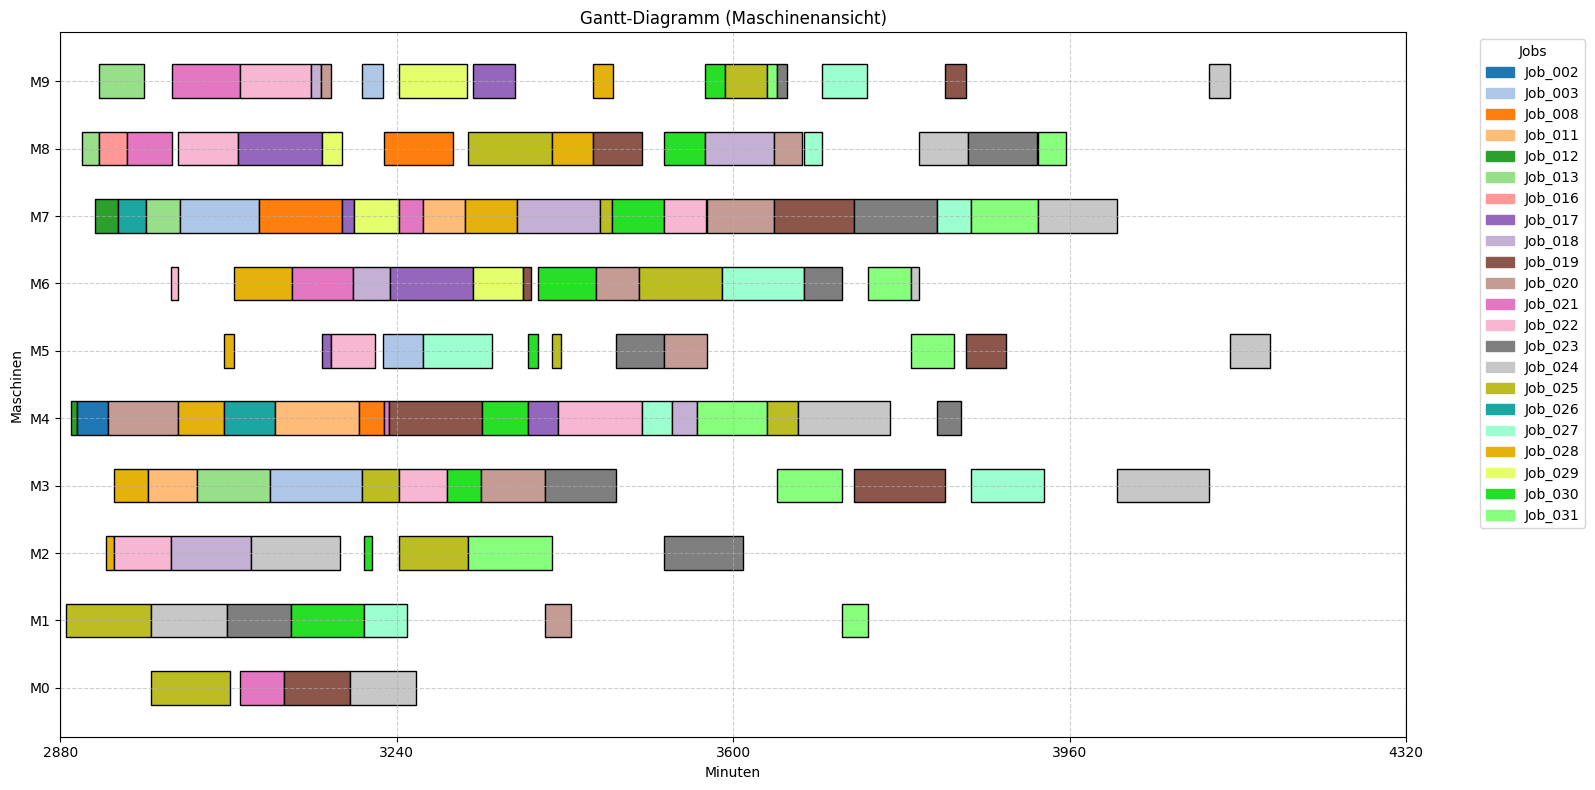

+ Keine Maschinenkonflikte gefunden
+ Alle Jobs wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten sind eingehalten.
+ Alle Operation starten erst nach Arrival des Job


True

In [32]:
show.plot_gantt_machines(df_reschedule)
check.is_machine_conflict_free(df_reschedule)
check.is_operation_sequence_correct(df_reschedule)
check.is_job_timing_correct(df_reschedule)
check.is_start_correct(df_reschedule)

In [33]:
last_ops = df_reschedule.sort_values(['Job', 'Operation']).drop_duplicates('Job', keep='last')
show.count_column_grouped(last_ops, "Lateness", max_val = 180, steps= 60)

label
<-180           0
-180 - -120     0
-120 - -60      1
-60 - 0         0
0               0
0 - 60          1
60 - 120        0
120 - 180       3
>180           17
Name: count, dtype: int64

In [34]:
filt = df_execution.Job == "Job_011"
df_execution[filt]


,Job,Operation,Arrival,Machine,Start,Simulated Processing Time,Flow time,End
102,Job_011,0,498,M1,2176.99,70.24,1749.23,2247.23
103,Job_011,1,498,M0,2247.23,10.97,1760.20,2258.20
104,Job_011,2,498,M2,2372.35,40.75,1915.10,2413.10
105,Job_011,3,498,M6,2568.01,5.16,2075.17,2573.17
106,Job_011,4,498,M8,2573.17,66.05,2141.22,2639.22
107,Job_011,5,498,M9,2672.00,87.12,2261.12,2759.12
108,Job_011,6,498,M5,2759.12,41.93,2303.05,2801.05


In [35]:
df_reschedule[df_reschedule.Job == "Job_011"]

,Job,Operation,Arrival,Deadline,Machine,Start,Processing Time,End,Lateness,Tardiness,Earliness
14,Job_011,7,498,2819,M3,2974,52,3026,207,207,0
34,Job_011,8,498,2819,M4,3110,90,3200,381,381,0
61,Job_011,9,498,2819,M7,3268,45,3313,494,494,0


### Combi aus Simulation und Neuplannung

In [36]:
# Relevante Spalten
columns_needed = ["Job", "Operation", "Arrival", "Machine", "Start", "Processing Time", "End"]

# Spalte in df_execution umbenennen
df_execution_important_renamed = df_execution.rename(columns={"Simulated Processing Time": "Processing Time"})

# Auf die gewünschten Spalten beschränken
df_exec_trimmed = df_execution_important_renamed[columns_needed]
df_resched_trimmed = df_reschedule[columns_needed]

# DataFrames zusammenführen
df_combined = pd.concat([df_exec_trimmed, df_resched_trimmed], ignore_index=True)
df_combined

,Job,Operation,Arrival,Machine,Start,Processing Time,End
0,Job_000,0,0,M0,1440.00,76.16,1516.16
1,Job_000,1,0,M1,1516.16,48.76,1564.92
2,Job_000,2,0,M2,1593.52,13.12,1606.64
3,Job_000,3,0,M3,1641.30,47.11,1688.41
4,Job_000,4,0,M4,1688.41,30.85,1719.26
...,...,...,...,...,...,...,...
315,Job_024,6,1238,M7,3926.00,85.00,4011.00
316,Job_031,9,1424,M8,3926.00,30.00,3956.00
317,Job_024,7,1238,M3,4011.00,98.00,4109.00
318,Job_024,8,1238,M9,4109.00,22.00,4131.00


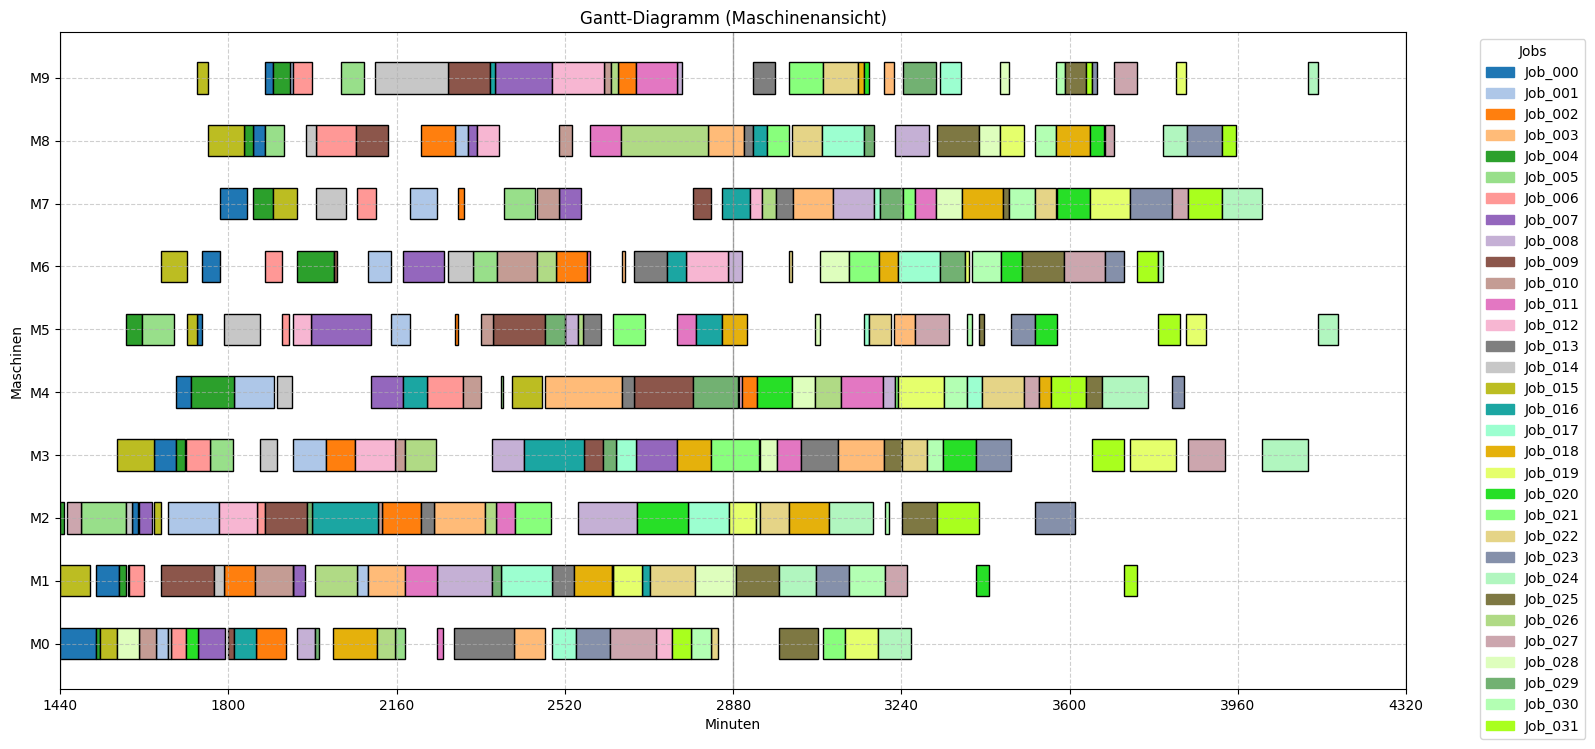

+ Keine Maschinenkonflikte gefunden
+ Alle Jobs wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten sind eingehalten.
+ Alle Operation starten erst nach Arrival des Job


True

In [37]:
show.plot_gantt_machines(df_combined)
check.is_machine_conflict_free(df_combined)
check.is_operation_sequence_correct(df_combined)
check.is_job_timing_correct(df_combined)
check.is_start_correct(df_combined)